<a href="https://colab.research.google.com/github/suyeonb/AI_lab_baesuyeon/blob/main/week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===== 과제 =====
#  - WaveRNN Vocoder, Griffin-Lim Vocoder, WaveGlow Vocoder를 모두 사용해서
#    '영문 자기소개' 문장의 음성을 만든다.

import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd

print("PyTorch:", torch.__version__)
print("torchaudio:", torchaudio.__version__)

# 코랩 기준 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 디바이스:", device)

PyTorch: 2.8.0+cu126
torchaudio: 2.8.0+cu126
사용 디바이스: cuda


In [2]:
def plot_and_play(waveforms, spec, sample_rate, title=""):
    """
    1) 위: 파형
    2) 아래: mel-spectrogram
   을 같이 그려주고, 실제 오디오도 재생해주는 작은 헬퍼 함수.
    """
    waveforms = waveforms.detach().cpu()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    if title:
        fig.suptitle(title)

    # 파형
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.set_ylabel("Amplitude")
    ax1.grid(True)

    # mel-spectrogram
    ax2.imshow(spec[0].detach().cpu(), origin="lower", aspect="auto")
    ax2.set_ylabel("Mel-Spectrogram")
    ax2.set_xlabel("Time")

    plt.show()

    # 코랩에서 들을 수 있는 오디오 위젯 반환
    return ipd.Audio(waveforms[0], rate=sample_rate)

In [3]:
intro_text = (
    "Hello, my name is Suyeon Bae. "
    "I am a computer science student in Korea, "
    "and I am interested in data, artificial intelligence, and creative projects."
)

print(intro_text)


Hello, my name is Suyeon Bae. I am a computer science student in Korea, and I am interested in data, artificial intelligence, and creative projects.


In [4]:
# ===== WaveRNN Vocoder 버전 =====
#  - torchaudio의 TACOTRON2_WAVERNN_CHAR_LJSPEECH 파이프라인 사용
#  - 문자(char) 단위 인코딩 + Tacotron2 + WaveRNN vocoder 조합

char_bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH

char_processor = char_bundle.get_text_processor()
char_tacotron2 = char_bundle.get_tacotron2().to(device)
char_vocoder = char_bundle.get_vocoder().to(device)

char_tacotron2.eval()
char_vocoder.eval()

with torch.inference_mode():
    # 텍스트 → 토큰
    tokens, token_lengths = char_processor(intro_text)
    tokens = tokens.to(device)
    token_lengths = token_lengths.to(device)

    # Tacotron2로 mel-spectrogram 생성
    char_spec, char_spec_lengths, _ = char_tacotron2.infer(tokens, token_lengths)

    # WaveRNN vocoder로 waveform 생성
    char_waveforms, char_wave_lengths = char_vocoder(char_spec, char_spec_lengths)

print("WaveRNN spec shape :", char_spec.shape)
print("WaveRNN waveform shape :", char_waveforms.shape)

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_characters_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_characters_1500_epochs_wavernn_ljspeech.pth


100%|██████████| 107M/107M [00:02<00:00, 39.7MB/s]


Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth


100%|██████████| 16.7M/16.7M [00:00<00:00, 26.9MB/s]


WaveRNN spec shape : torch.Size([1, 80, 821])
WaveRNN waveform shape : torch.Size([1, 225775])


In [6]:
!pip install deep-phonemizer

  Preparing metadata (setup.py) ... done
  Created wheel for deep-phonemizer: filename=deep_phonemizer-0.0.19-py3-none-any.whl size=33272 sha256=6e90ed348ea46678bad9404aed0e57e2009df768902d585503e5ed4433c68c50
  Stored in directory: /root/.cache/pip/wheels/b9/d7/45/f2ae07184a29327b2a7f93b1f734a936c3a34e57225fca603b
Successfully built deep-phonemizer


In [7]:
!pip install phonemizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.0/569.0 kB 21.2 MB/s eta 0:00:00


In [8]:
# ===== Griffin-Lim Vocoder 버전 =====
#  - TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH 파이프라인 사용
#  - 음소(phone) 단위 인코딩 + Tacotron2 + Griffin-Lim vocoder 조합

gl_bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

gl_processor = gl_bundle.get_text_processor()
gl_tacotron2 = gl_bundle.get_tacotron2().to(device)
gl_vocoder = gl_bundle.get_vocoder().to(device)

gl_tacotron2.eval()
gl_vocoder.eval()

with torch.inference_mode():
    gl_tokens, gl_token_lengths = gl_processor(intro_text)
    gl_tokens = gl_tokens.to(device)
    gl_token_lengths = gl_token_lengths.to(device)

    gl_spec, gl_spec_lengths, _ = gl_tacotron2.infer(gl_tokens, gl_token_lengths)

    # Griffin-Lim 알고리즘 기반 vocoder
    gl_waveforms, gl_wave_lengths = gl_vocoder(gl_spec, gl_spec_lengths)

print("Griffin-Lim spec shape :", gl_spec.shape)
print("Griffin-Lim waveform shape :", gl_waveforms.shape)

100%|██████████| 63.6M/63.6M [00:03<00:00, 17.4MB/s]
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth


100%|██████████| 107M/107M [00:02<00:00, 50.6MB/s]


Griffin-Lim spec shape : torch.Size([1, 80, 863])
Griffin-Lim waveform shape : torch.Size([1, 220672])


In [9]:
# ===== WaveGlow Vocoder 버전 =====
#  - NVIDIA/DeepLearningExamples의 WaveGlow 모델을 torch.hub로 로드
#  - 위에서 만든 gl_spec (Tacotron2의 mel-spectrogram)을 WaveGlow에 넣어서 음성 생성

waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    # gl_spec: [batch, mel, time] 형태의 mel-spectrogram
    # WaveGlow는 입력을 GPU로 올린 뒤 infer를 호출하면 waveform 반환
    wg_waveforms = waveglow.infer(gl_spec.to(device))

print("WaveGlow waveform shape :", wg_waveforms.shape)


/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip


/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


WaveGlow waveform shape : torch.Size([1, 220928])


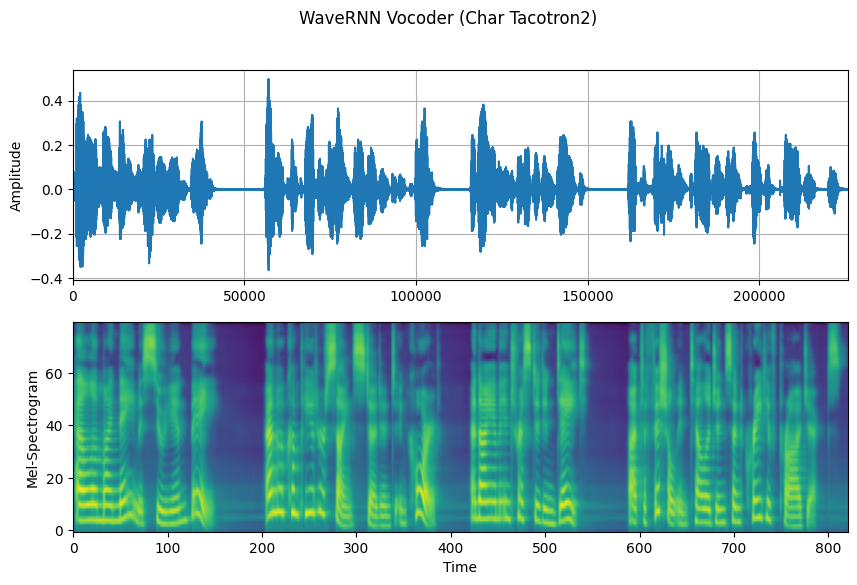

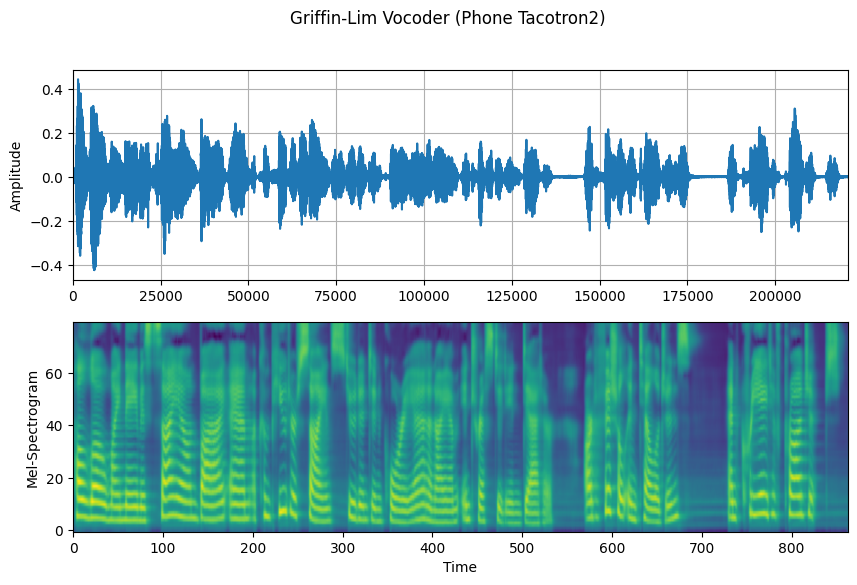

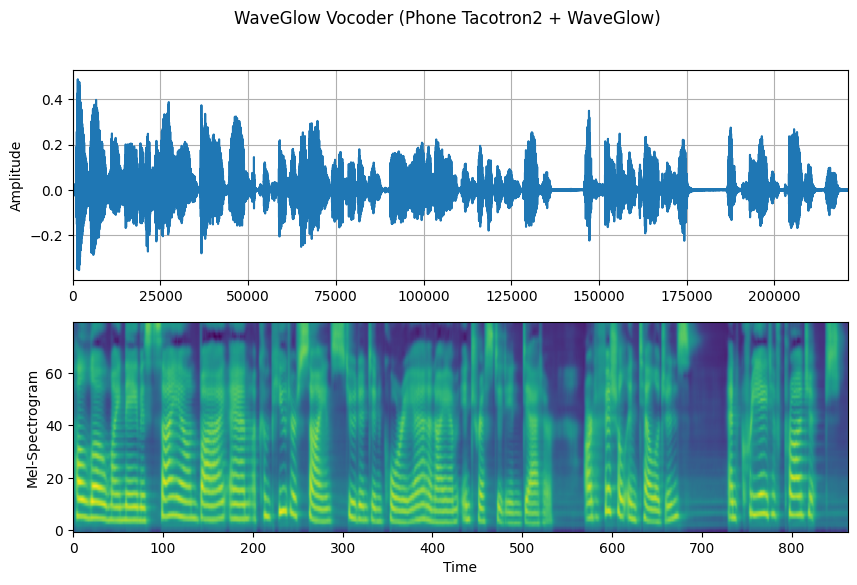

In [10]:
# WaveRNN 결과
audio_char = plot_and_play(
    char_waveforms,
    char_spec,
    sample_rate=char_vocoder.sample_rate,
    title="WaveRNN Vocoder (Char Tacotron2)"
)
display(audio_char)

# Griffin-Lim 결과
audio_gl = plot_and_play(
    gl_waveforms,
    gl_spec,
    sample_rate=gl_vocoder.sample_rate,
    title="Griffin-Lim Vocoder (Phone Tacotron2)"
)
display(audio_gl)

# WaveGlow 결과 (WaveGlow는 보통 22050 Hz 사용)
audio_wg = plot_and_play(
    wg_waveforms,
    gl_spec,
    sample_rate=22050,
    title="WaveGlow Vocoder (Phone Tacotron2 + WaveGlow)"
)
display(audio_wg)